In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kneed as kn
import plotly.graph_objects as go
import random

In [37]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

In [38]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [39]:
df = pd.read_csv('train_pca.csv')
del df['Unnamed: 0']
df

,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
0,-0.346579,0.098145,-0.806746,-0.427913,0.328098
1,-1.618868,-0.365689,0.405130,-0.254094,-0.970461
2,-0.763450,-0.721884,0.720200,0.806694,0.062175
3,-0.506804,0.166461,-0.184220,1.056516,-0.478649
4,7.945215,-0.716464,-1.416758,-0.013609,0.743721
...,...,...,...,...,...
15920,0.898226,-2.430100,0.605703,-0.643798,0.342123
15921,-0.837187,-1.080911,1.081214,1.001772,-0.389527
15922,5.465723,0.093960,0.320247,2.075547,-0.373623
15923,4.999930,-3.485802,-0.475646,0.735213,-0.731691


In [40]:
df.head()

,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
0,-0.346579,0.098145,-0.806746,-0.427913,0.328098
1,-1.618868,-0.365689,0.405130,-0.254094,-0.970461
2,-0.763450,-0.721884,0.720200,0.806694,0.062175
3,-0.506804,0.166461,-0.184220,1.056516,-0.478649
4,7.945215,-0.716464,-1.416758,-0.013609,0.743721


In [41]:
df.describe()

,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
count,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04
mean,4.640279e-17,-2.097049e-17,5.309550e-17,1.784723e-18,-8.923614e-18
std,2.063024e+00,1.196257e+00,1.043604e+00,9.702996e-01,9.016430e-01
min,-2.125705e+00,-4.153832e+00,-5.442170e+00,-4.154836e+00,-5.957225e+00
25%,-1.222967e+00,-7.264520e-01,-6.123275e-01,-5.709878e-01,-5.172481e-01
50%,-6.266554e-01,1.064962e-01,-6.461689e-02,2.753387e-02,3.319548e-02
75%,4.488364e-01,7.346950e-01,5.516331e-01,5.937905e-01,5.329868e-01
max,2.071558e+01,7.826389e+00,7.451328e+00,8.326927e+00,8.310961e+00


In [42]:
# del df['popularityIndex']
# del df['originalTitle']
# del df['rating']
# del df['titleType']
# del df['countryOfOrigin']
# del df['genres']
# del df['isAdult']
# del df['isRatable']
# del df['canHaveEpisodes']

In [43]:
df.head()

,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
0,-0.346579,0.098145,-0.806746,-0.427913,0.328098
1,-1.618868,-0.365689,0.405130,-0.254094,-0.970461
2,-0.763450,-0.721884,0.720200,0.806694,0.062175
3,-0.506804,0.166461,-0.184220,1.056516,-0.478649
4,7.945215,-0.716464,-1.416758,-0.013609,0.743721


In [44]:
#NORMALIZZAZIONE MINMAX O ZSCORE, COMMMENTARE UNA DELLE DUE RIGHE IN BASE AL TIPO DI NORMALIZZAZIONE CHE SI VUOLE UTILIZZARE
#NORMALIZZAZIONE MINMAX O ZSCORE, COMMMENTARE UNA DELLE DUE RIGHE IN BASE AL TIPO DI NORMALIZZAZIONE CHE SI VUOLE UTILIZZARE
#PER I NOSTRI DATI SEMBRA MEGLIO MIN/MAX
#PER I NOSTRI DATI SEMBRA MEGLIO MIN/MAX

# scaler = MinMaxScaler()

scaler = StandardScaler()

train_data = scaler.fit_transform(df)


In [45]:
def create_kdistance_graph(data, k):
  """Crea un grafico k-distance per i dati.

  Args:
    data: Un array numpy contenente i dati.
    k: Il numero di vicini da considerare.

  Returns:
    Un array numpy contenente le distanze k-esimo vicino per ogni punto.
  """

  # Calcola le distanze ai k vicini più vicini per ogni punto
  nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(data)
  distances, indices = nbrs.kneighbors(data)

  # Prendi la distanza dal k-esimo vicino più vicino
  distances = distances[:, k]
  distances = np.sort(distances, axis=0)

  return distances

In [46]:
# Esempio di utilizzo
epsilon_list = []

for k in range(2,51): # Numero di vicini
    distances = create_kdistance_graph(train_data, k)
    x = np.arange(len(distances))
    kn = KneeLocator(x, distances, curve='convex', direction='increasing')
    elbow_k = kn.elbow
    epsilon = distances[elbow_k]
    epsilon_list.append(epsilon)
    print("Epsilon ottimale secondo il metodo del gomito: k={} epsilon={}".format(k, epsilon))

media_epsilon = np.mean(epsilon_list)
print("La media degli epsilon è:", media_epsilon)


Epsilon ottimale secondo il metodo del gomito: k=2 epsilon=1.366134981697798
Epsilon ottimale secondo il metodo del gomito: k=3 epsilon=1.4184416607148862
Epsilon ottimale secondo il metodo del gomito: k=4 epsilon=1.417184145634875
Epsilon ottimale secondo il metodo del gomito: k=5 epsilon=1.2917422431862633
Epsilon ottimale secondo il metodo del gomito: k=6 epsilon=1.4497995975760019
Epsilon ottimale secondo il metodo del gomito: k=7 epsilon=2.8616986786958067
Epsilon ottimale secondo il metodo del gomito: k=8 epsilon=2.8671314246595716
Epsilon ottimale secondo il metodo del gomito: k=9 epsilon=1.6226697191130734
Epsilon ottimale secondo il metodo del gomito: k=10 epsilon=3.7906492682950033
Epsilon ottimale secondo il metodo del gomito: k=11 epsilon=1.5144237030424115
Epsilon ottimale secondo il metodo del gomito: k=12 epsilon=2.9339293285902905
Epsilon ottimale secondo il metodo del gomito: k=13 epsilon=4.132226247949984
Epsilon ottimale secondo il metodo del gomito: k=14 epsilon=1.8

2.1732616365055315


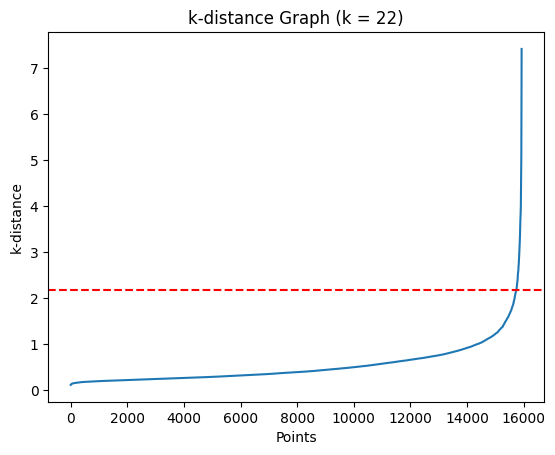

In [47]:
distances = create_kdistance_graph(train_data, 22)
kn = KneeLocator(x, distances, curve='convex', direction='increasing')
elbow_k = kn.elbow
epsilon = distances[elbow_k]
print(epsilon)

# Plotta il grafico
plt.plot(distances)
# Aggiungi la linea orizzontale
plt.axhline(y=epsilon, color='r', linestyle='--')
plt.xlabel('Points')
plt.ylabel('k-distance')
plt.title('k-distance Graph (k = 22)')
plt.show()

In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Definisci i parametri per la grid search
param_grid = {
    'eps': np.arange(0.8, 3.0, 0.3),
    'min_samples': np.arange(2, 12, 2)
}

# Inizializza una lista per memorizzare i risultati
results = []

# Esegui la grid search
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], metric='cityblock')
    dbscan.fit(train_data)
    
    # Calcola il numero di cluster (escludendo il rumore)
    n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    
    # Calcola il silhouette score (escludendo i punti rumorosi)
    if n_clusters > 1:
        silhouette = silhouette_score(train_data[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])
    else:
        silhouette = -1  # Silhouette score non definito per un singolo cluster
    
    # Memorizza i risultati
    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'silhouette': silhouette
    })

# Converti i risultati in un DataFrame per una visualizzazione più semplice
results_df = pd.DataFrame(results)
results_df

,eps,min_samples,n_clusters,silhouette
0,0.8,2,322,-0.446997
1,0.8,4,66,-0.368604
2,0.8,6,37,-0.284373
3,0.8,8,20,-0.235628
4,0.8,10,23,-0.309703
5,1.1,2,172,-0.356578
6,1.1,4,34,-0.101518
7,1.1,6,12,-0.053249
8,1.1,8,5,-0.094147
9,1.1,10,6,-0.072746


Dal metodo dell'elbow i cluster formati non sono bilanciati. quindi si procede con una grid search cambiando l'eps e il valore del min_samples ma comunque non si sono combinazioni dove i cluster sono ben bilanciati

In [49]:
# density based clustering
print('DBSCAN')

dbscan = DBSCAN(eps=2.6, min_samples=4, metric='cityblock')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))

DBSCAN
labels {np.int64(-1): np.int64(107), np.int64(0): np.int64(15807), np.int64(1): np.int64(5), np.int64(2): np.int64(6), np.int64(3): np.int64(0)}
silhouette 0.4638598591733266


In [50]:
train_data = pd.DataFrame(train_data)

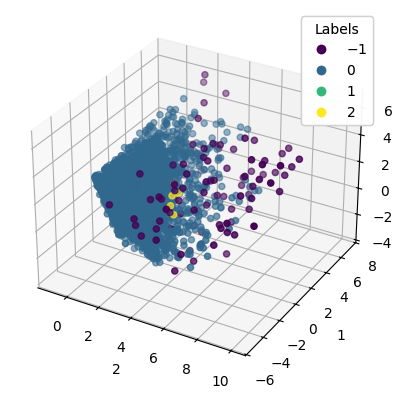

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Supponiamo che 'df' sia il tuo DataFrame e 'variable_3' sia la terza variabile
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crea il grafico 3D
scatter = ax.scatter(train_data[0], train_data[2], train_data[1], 
                     c=dbscan.labels_, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('2')
ax.set_ylabel('1')
ax.set_zlabel('3')

# Aggiungi una legenda
legend1 = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend1)

# Mostra il grafico
plt.show()

In [52]:
train_data.describe()

,0,1,2,3,4
count,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04
mean,1.606250e-17,-1.249306e-17,2.654775e-17,-1.784723e-18,-6.246530e-18
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.030415e+00,-3.472468e+00,-5.214951e+00,-4.282148e+00,-6.607285e+00
25%,-5.928214e-01,-6.072901e-01,-5.867618e-01,-5.884839e-01,-5.736909e-01
50%,-3.037652e-01,8.902735e-02,-6.191903e-02,2.837756e-02,3.681781e-02
75%,2.175692e-01,6.141810e-01,5.286015e-01,6.119854e-01,5.911469e-01
max,1.004168e+01,6.542605e+00,7.140223e+00,8.582080e+00,9.217864e+00


In [53]:
# Calcolo delle statistiche per ogni cluster
unique_labels = set(dbscan.labels_)
cluster_stats = {}

for label in unique_labels:
    if label != -1:  # Ignora il rumore
        cluster_points = train_data[dbscan.labels_ == label]
        cluster_stats[label] = {
            'num_points': len(cluster_points),
            'mean': np.mean(cluster_points, axis=0),
            'std_dev': np.std(cluster_points, axis=0)
        }

print("Cluster Statistics:")
for label, stats in cluster_stats.items():
    print(f"Cluster {label}:")
    print(f"  Number of Points: {stats['num_points']}")
    print(f"  Mean: {stats['mean']}")
    print(f"  Standard Deviation: {stats['std_dev']}")

Cluster Statistics:
Cluster 0:
  Number of Points: 15807
  Mean: 0   -0.034276
1   -0.011270
2   -0.005788
3   -0.003371
4    0.003792
dtype: float64
  Standard Deviation: 0    0.891058
1    0.972569
2    0.973345
3    0.975901
4    0.938947
dtype: float64
Cluster 1:
  Number of Points: 5
  Mean: 0    0.716467
1   -1.687205
2    2.340755
3    4.148775
4    6.098536
dtype: float64
  Standard Deviation: 0    0.368004
1    0.366225
2    0.338113
3    0.306806
4    0.684726
dtype: float64
Cluster 2:
  Number of Points: 6
  Mean: 0    3.629767
1    1.176716
2   -0.501955
3   -0.952304
4   -2.298868
dtype: float64
  Standard Deviation: 0    0.285425
1    0.558331
2    0.665591
3    0.427342
4    0.508825
dtype: float64
